In [2]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

In [33]:
def collect_data_and_plot(df, test_mode, setting_name, underage_cost):
    # Filter the dataframe for the specified underage cost
    df = df[df['store_underage_cost'] == underage_cost]
    def run_main_run(row):
        try:
            cmd = [
                "/user/ml4723/.conda/envs/neural_inventory_control/bin/python",
                "main_run.py",
                test_mode, # test or test_on_dev
                setting_name,
                row['hyperparam_name'],
                row['path'],
                row['Architecture Class']
            ]
            env = {
                **os.environ,
                "MKL_THREADING_LAYER": "GNU",
                "MKL_SERVICE_FORCE_INTEL": "1"
            }
            subprocess.run(cmd, capture_output=True, text=True, check=True, env=env, cwd="/user/ml4723/Prj/NIC/")
        except subprocess.CalledProcessError as e:
            print(f"Error running main_run.py for path {row['path']}: {e}")
            print(f"Error output: {e.stderr}")
        except Exception as e:
            print(f"Unexpected error running main_run.py for path {row['path']}: {e}")

    def get_file_name(row):
        return f"results/one_warehouse_real/{row['# of stores']}/{row['Architecture Class']}/{underage_cost}.csv"
    
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        futures = []
        for _, row in df.iterrows():
            file_name = get_file_name(row)
            if os.path.exists(file_name):
                continue
            while len(futures) >= 24:
                done, not_done = concurrent.futures.wait(
                    futures, 
                    return_when=concurrent.futures.FIRST_COMPLETED
                )
                futures = list(not_done)
            futures.append(executor.submit(run_main_run, row))
        concurrent.futures.wait(futures)
    
    avg_s_underage = []
    avg_s_holding = []
    avg_w_holding = []
    avg_cost = []
    for _, row in df.iterrows():
        file_name = get_file_name(row)
        data = pd.read_csv(file_name)
        n_samples = 4096
        batch_size = 4096
        num_batches = n_samples // batch_size
        num_steps = 500
        start_step = 300
        
        relevant_indices = []
        for batch in range(num_batches):
            batch_start = batch * batch_size * num_steps
            step_start = batch_start + start_step * batch_size
            step_end = batch_start + num_steps * batch_size
            relevant_indices.extend(range(step_start, step_end))
        relevant_data = data.iloc[relevant_indices]
        
        n_stores = row['# of stores']
        avg_s_underage.append(relevant_data['s_underage_costs'].mean() / underage_cost)
        avg_s_holding.append(relevant_data['s_holding_costs'].mean() / underage_cost)
        avg_w_holding.append(relevant_data['w_holding_costs'].mean() / underage_cost)
        avg_cost.append(relevant_data['s_underage_costs'].sum() * n_stores + relevant_data['s_holding_costs'].sum() * n_stores + relevant_data['w_holding_costs'].sum())

    # Create a copy of the dataframe to avoid SettingWithCopyWarning
    df_copy = df.copy()
    df_copy['avg_s_underage'] = avg_s_underage
    df_copy['avg_s_holding'] = avg_s_holding
    df_copy['avg_w_holding'] = avg_w_holding 
    df_copy['avg_cost'] = avg_cost
    df = df_copy

    # Calculate relative cost
    # Calculate cost as percentage of lowest cost
    # Calculate min cost for each number of stores
    df['cost'] = df.groupby('# of stores')['avg_cost'].transform(lambda x: x/x.min() * 100)

    plot_data = df.pivot(index="# of stores", columns='Architecture Class', 
                         values=['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding'])
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 12))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easier iteration
    titles = ['Cost (% of minimum at each # of stores)', 'Average Store lost sales / (average unit underage cost)', 'Average Store Holding Cost / (average unit underage cost)', 'Average Warehouse Holding Cost / (average unit underage cost)']
    y_values = ['cost', 'avg_s_underage', 'avg_s_holding', 'avg_w_holding']

    x_values = df['# of stores'].unique()
    for i, (ax, title, y_value) in enumerate(zip(axes, titles, y_values)):
        for arch in df['Architecture Class'].unique():
            if arch == 'Just_In_Time':
                continue
            if arch in plot_data[y_value].columns:
                ax.plot(x_values, plot_data[y_value][arch].loc[x_values], marker='o', label=f'{arch}', 
                        color=color_scheme[arch], linestyle=linestyle_scheme[arch])
        
        ax.set_xlabel('Number of stores')
        ax.set_ylabel(f'{title}')
        ax.set_title(title)
        ax.legend()
        ax.grid(True)
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_values)
    
    plt.tight_layout()
    plt.show()
    return df


   store_underage_cost  # of stores                         Architecture Class  Train Loss  Dev Loss  Test Loss  # of runs  Test Gap %                                                                                                                                                                                                                                                        path
0                    9            1  One_Store_And_One_Warehouse_For_Warehouse    5.128097  5.117309   5.138089         12         0.0  /user/ml4723/Prj/NIC/ray_results/store_disruption_independent_store_debug_2/run_2024-12-01_20-24-01/run_1cbb3_00010_10_learning_rate=0.0010,omit_context_from_store_input=True,samples=4,store_orders_for_warehouse=False,store_undera_2024-12-01_20-24-01


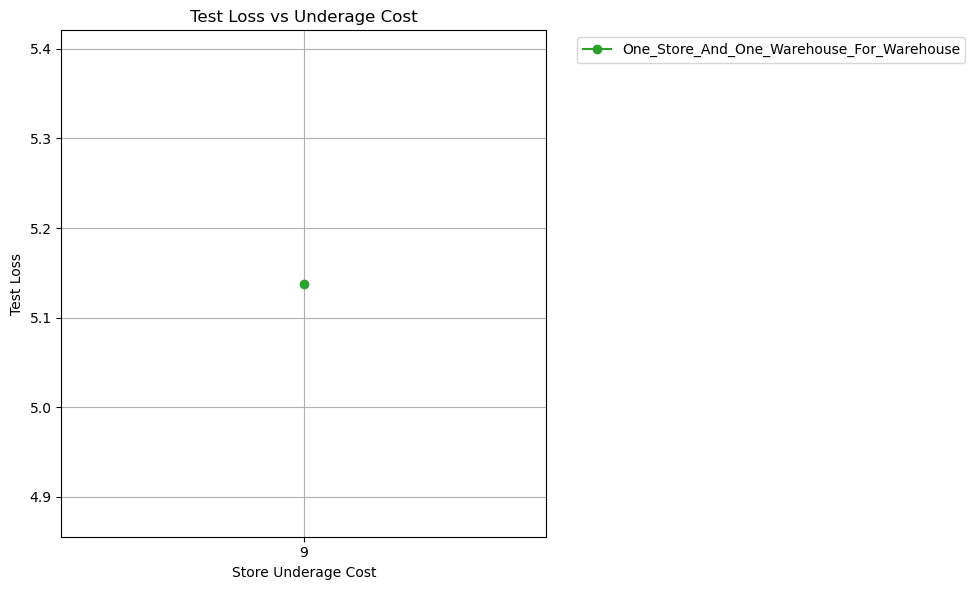

In [9]:
# Define color scheme for architecture types
color_scheme = {
    "One_Store_And_One_Warehouse_For_Warehouse": "#2ca02c",  # Green
}

linestyle_scheme = {
    "One_Store_And_One_Warehouse_For_Warehouse": "-",  # Solid
}

path = 'store_disruption_independent_store_debug_2'
store_paths = {
    1: f'/user/ml4723/Prj/NIC/ray_results/{path}',
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'omit_context_from_store_input':
        return False
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

store_underage_cost = [9]
results_interpretor = rri.RayResultsinterpreter()

# One store for warehouse
df_store = results_interpretor.make_table(store_paths, 
    {'store_underage_cost': store_underage_cost,}, 
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_store.insert(1, 'Architecture Class', "One_Store_And_One_Warehouse_For_Warehouse")
df_store.insert(1, 'hyperparam_name', "symmetry_aware")

# Combine dataframes
df = df_store.copy()

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate'], inplace=True)

print(df_to_print.to_string())

# Create the plot for fixed case
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Loss - handle duplicate entries by taking mean
pivot_df_fixed_test = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Loss'].mean().unstack()

for column in pivot_df_fixed_test.columns:
    ax.plot(pivot_df_fixed_test.index, pivot_df_fixed_test[column], 
            marker='o', 
            label=column, 
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Loss')
ax.set_title('Test Loss vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df_fixed_test.index)

plt.tight_layout()
plt.show()

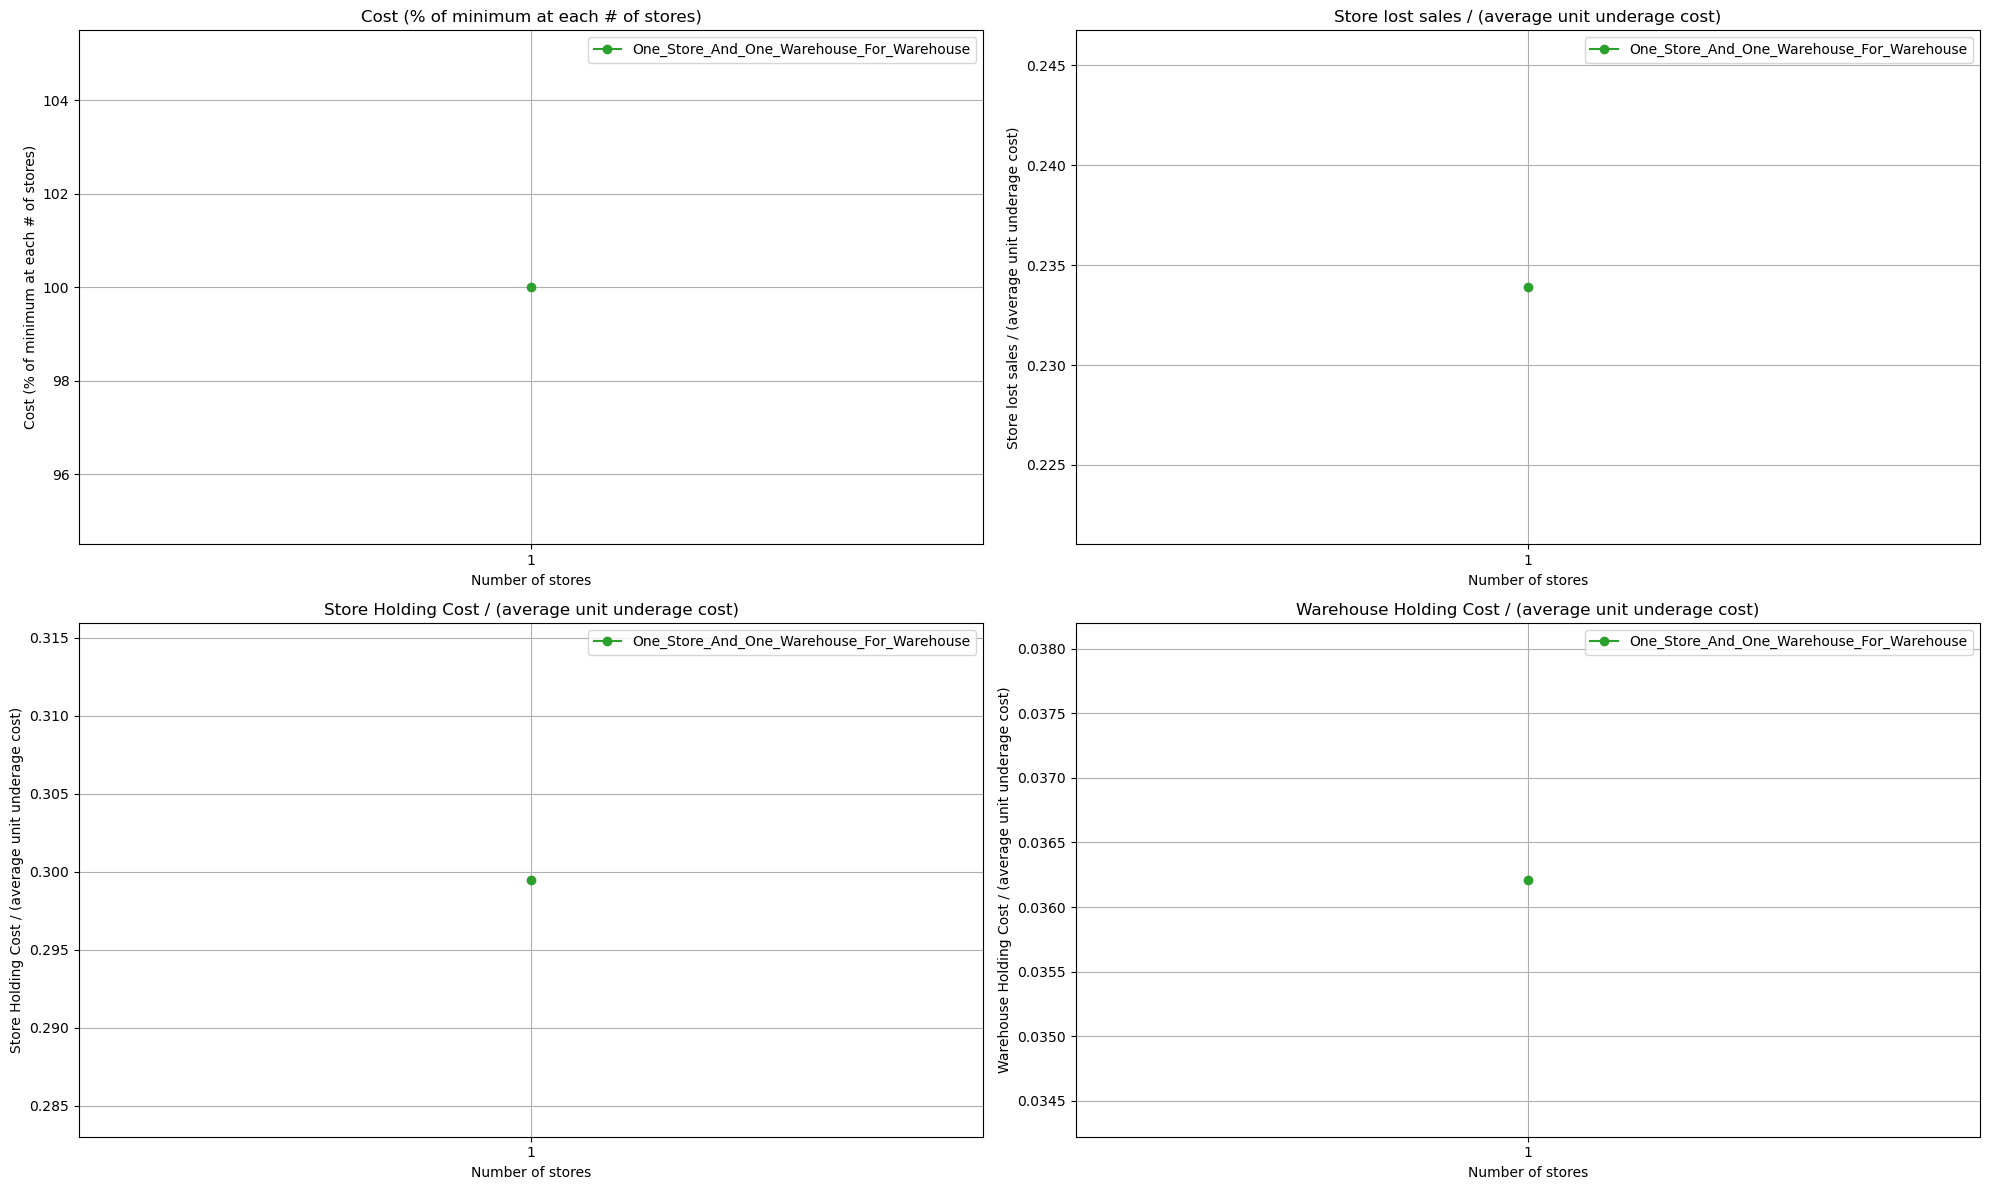

In [15]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand_random_yield_independent_store_debug", 9)

   # of stores Architecture Class  Train Loss  Dev Loss  Test Loss  Test Gap %                                                                                                                                                                                                                                                  path  # of runs
0            3   Decentralized_WC    6.158590  6.171550   6.163556    0.282053   /user/ml4723/Prj/NIC/ray_results/store_disruption_2/symmetry_aware/3/run_2024-12-01_20-54-31/run_5f488_00004_4_learning_rate=0.0010,omit_context_from_store_input=True,samples=2,store_orders_for_warehouse=False,store_underag_2024-12-01_20-54-31         12
0            3     Symmetry_Aware    6.138587  6.155933   6.147969    0.028441   /user/ml4723/Prj/NIC/ray_results/store_disruption_2/symmetry_aware/3/run_2024-12-01_20-44-00/run_e72a1_00016_16_learning_rate=0.0010,omit_context_from_store_input=False,samples=2,store_orders_for_warehouse=False,store_under_2024-12-01_20-44-00    

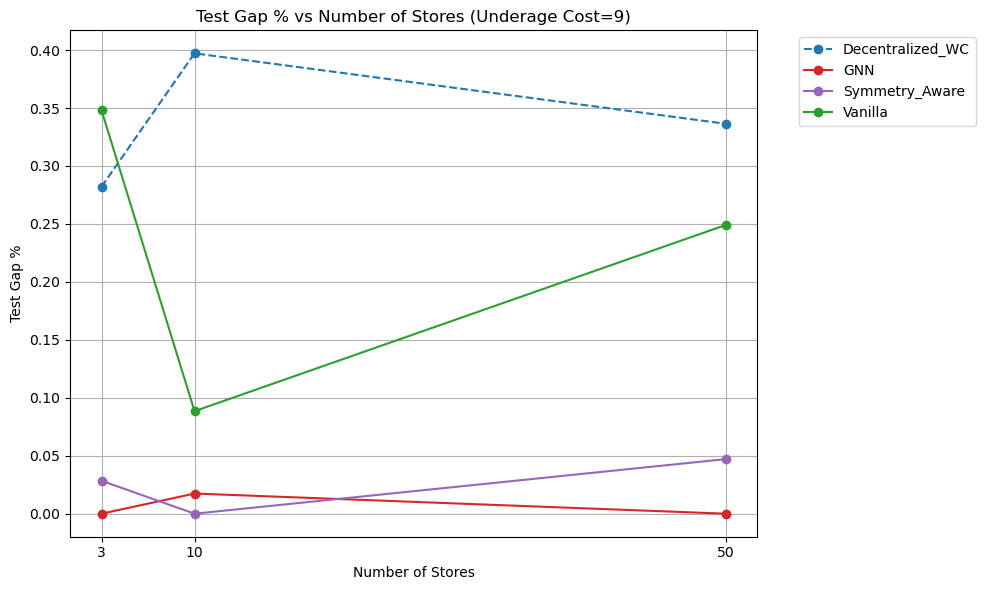

In [37]:
# Define color scheme for architecture types
color_scheme = {
    "Decentralized_store_orders_for_warehouse": "#1f77b4",  # Blue
    "Decentralized_WC": "#1f77b4",  # Blue 
    "Decentralized": "#1f77b4",  # Blue
    "Symmetry_Aware_store_orders_for_warehouse": "#9467bd",  # Purple
    "Symmetry_Aware": "#9467bd",  # Purple
    "Pretrained_Store_WC": "#ff7f0e",  # Orange
    "Pretrained_Store": "#ff7f0e",  # Orange
    "Vanilla": "#2ca02c",  # Green
    "GNN": "#d62728",  # Red
}

linestyle_scheme = {
    "Decentralized_store_orders_for_warehouse": "--",  # Dashed
    "Decentralized_WC": "--",  # Dashed
    "Decentralized": "-",  # Solid
    "Symmetry_Aware_store_orders_for_warehouse": "--",  # Dashed
    "Symmetry_Aware": "-",  # Solid
    "Pretrained_Store_WC": "--",  # Dashed
    "Pretrained_Store": "-",  # Solid
    "Vanilla": "-",  # Solid
    "GNN": "-",  # Solid
}

path = 'store_disruption_2'
decentralized_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized/50'
}
symmetry_aware_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/symmetry_aware/50'
}
decentralized_independent_store_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized_independent_store/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized_independent_store/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/decentralized_independent_store/50'
}
hdpo_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/HDPO/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/HDPO/10', 
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/HDPO/50'
}
gnn_paths = {
    3: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN/3',
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN/10',
    50: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN/50'
}

def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    if condition_name == 'store_orders_for_warehouse':
        return False
    return None

sort_by = 'test_loss'
pick_row_from_run_by = 'test_loss'

store_underage_cost = [9]  # Only using underage cost of 9
results_interpretor = rri.RayResultsinterpreter()

# Basic Decentralized
df_decentralized = results_interpretor.make_table(decentralized_paths,
    {'store_underage_cost': store_underage_cost, 'store_orders_for_warehouse': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized.insert(2, 'Architecture Class', "Decentralized")
df_decentralized.insert(1, 'hyperparam_name', "decentralized")

# Decentralized without context
df_decentralized_wc = results_interpretor.make_table(symmetry_aware_paths,
    {'store_underage_cost': store_underage_cost, 'store_orders_for_warehouse': False, 'omit_context_from_store_input': True},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_decentralized_wc.insert(2, 'Architecture Class', "Decentralized_WC")
df_decentralized_wc.insert(1, 'hyperparam_name', "symmetry_aware")

# Pretrained Store with context
df_pretrained_store_wc = results_interpretor.make_table(decentralized_independent_store_paths,
    {'store_underage_cost': store_underage_cost, 'include_context_for_warehouse_input': True},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_pretrained_store_wc.insert(2, 'Architecture Class', "Pretrained_Store_WC")
df_pretrained_store_wc.insert(1, 'hyperparam_name', "decentralized_independent_store")

# Pretrained Store
df_pretrained_store = results_interpretor.make_table(decentralized_independent_store_paths,
    {'store_underage_cost': store_underage_cost, 'include_context_for_warehouse_input': [False]},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_pretrained_store.insert(2, 'Architecture Class', "Pretrained_Store")
df_pretrained_store.insert(1, 'hyperparam_name', "decentralized_independent_store")

# Basic Symmetry aware
df_symmetry_aware = results_interpretor.make_table(symmetry_aware_paths,
    {'store_underage_cost': store_underage_cost, 'store_orders_for_warehouse': False, 'omit_context_from_store_input': False},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_symmetry_aware.insert(2, 'Architecture Class', "Symmetry_Aware")
df_symmetry_aware.insert(1, 'hyperparam_name', "symmetry_aware")

# HDPO
df_hdpo = results_interpretor.make_table(hdpo_paths,
    {'store_underage_cost': store_underage_cost},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_hdpo.insert(2, 'Architecture Class', "Vanilla")
df_hdpo.insert(1, 'hyperparam_name', "vanilla_one_warehouse")

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {'store_underage_cost': store_underage_cost},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(2, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# Combine dataframes
df = pd.concat([
    # df_pretrained_store,
    # df_pretrained_store_wc,
    # df_decentralized,
    df_decentralized_wc,
    df_symmetry_aware,
    df_hdpo,
    df_gnn
])

min_test_loss = df.groupby(['# of stores'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.sort_values(by=['# of stores'], inplace=True)
# Move '# of runs' column to the end
if '# of runs' in df.columns:
    runs_col = df.pop('# of runs')
    df['# of runs'] = runs_col


df_to_print = df.copy()
columns_to_drop = ['store_underage_cost', 'Learning Rate', 'include_context_for_warehouse_input', 'hyperparam_name', 'store_orders_for_warehouse', 'omit_context_from_store_input']
df_to_print.drop(columns=[col for col in columns_to_drop if col in df_to_print.columns], inplace=True)
print(df_to_print.to_string())

# Create single plot
fig, ax = plt.subplots(figsize=(10, 6))

# Create pivot table
pivot_df = df.groupby(['# of stores', 'Architecture Class'])['Test Gap %'].mean().unstack()

# Plot lines for each architecture
for column in pivot_df.columns:
    ax.plot(pivot_df.index, pivot_df[column],
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Number of Stores')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Number of Stores (Underage Cost=9)')
ax.grid(True)
ax.set_xticks(pivot_df.index)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

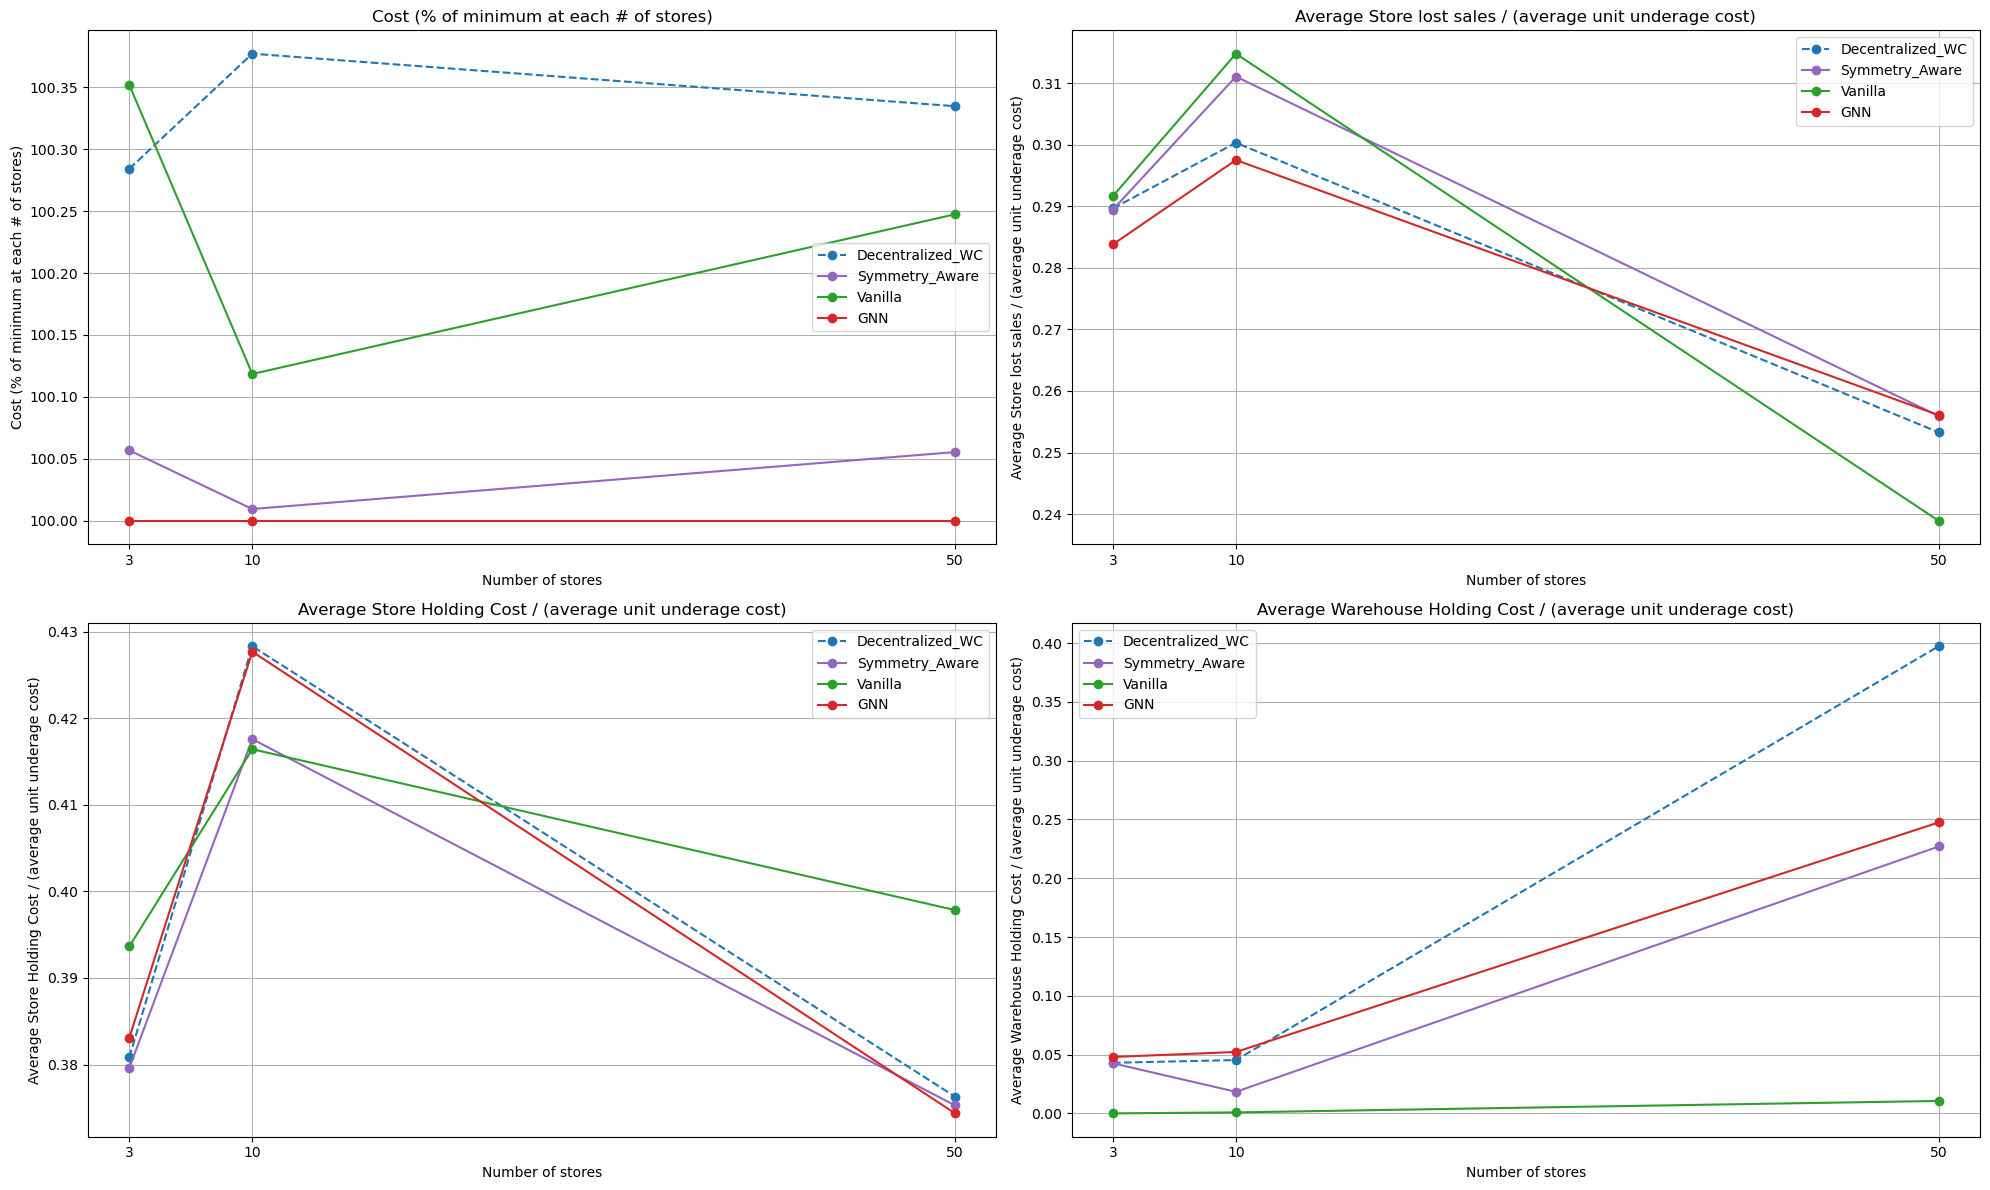

In [38]:
df_t = collect_data_and_plot(df, "test", "one_warehouse_lost_demand_random_yield", 9)